# McArthur Forest Fire Danger Index (FFDI) computation

Doug Richardson (CSIRO): doug.richardson@csiro.au

This notebook details how we compute the FFDI from model data (either the JRA reanalysis or ACCESS-D hindcasts) for our work. We use the formula provided in Dowdy (2018) https://journals.ametsoc.org/view/journals/apme/57/2/jamc-d-17-0167.1.xml, with the following differences:

- The drought factor is not calculated using the Keetch-Byram Drought Index (KBDI), as the procedure for the computing the KBDI is rather involved and empirical. We use 20-day accumulated rainfall instead.
- We do not calibrate our wind speed data in the same way as Dowdy (2018), who used 10-minute NWP forecasts to calibrate mid-afternoon wind speed. We instead use daily max wind speed from JRA, or daily mean wind speed from ACCESS-D (as there is no max wind speed in that data set).
- We can take relative humidity from the model directly, rather than having to estimate it using vapour pressure. We use mid-afternoon (0600 UTC) relative humidity from JRA, but Dougie uses daily mean relative humidity in his work as that's what's available in ACCESS-D. For the same reason, Dougie uses relative humidity at 1000 hPa rather than at the surface.

## FFDI variables:
- daily mean or mid-afternoon relative humidity at 2 m or 1000 hPa ($H$)
- daily max or mean 10 m wind speed ($W$)
- daily max 2 m temperature ($T$)
- drought factor ($D$)

## FFDI formula:
## $$\mathit{FFDI} = D^{0.987} \cdot \mbox{exp}(0.0338T - 0.0345H + 0.0234W + 0.243147)$$

where here $D$ is the 20-day accumulated rainfall, $p_{20}$, scaled to lie between 0 and 10 (Richardson et al. 2021):

## $$D = -10 \cdot \frac{p_{20} - \min(p_{20})}{\max(p_{20})-\min(p_{20})} + 10.$$

# Code for calculating the FFDI using the JRA reanalysis

In [1]:
import xarray as xr
import numpy as np
import carsa

## Load JRA data

In [2]:
jra_ds = xr.open_zarr('./example_data/JRA55_surface_Aus_2019-2020.zarr.zip', consolidated=True)

In [3]:
jra_ds = jra_ds.rename({'initial_time0_hours': 'time'})

In [4]:
jra_ds.data_vars

Data variables:
    RH_GDS0_HTGL    (time, g0_lat_1, g0_lon_2) float32 dask.array<chunksize=(731, 29, 36), meta=np.ndarray>
    TMAX_GDS4_HTGL  (time, g0_lat_1, g0_lon_2) float32 dask.array<chunksize=(731, 29, 36), meta=np.ndarray>
    TPRAT_GDS0_SFC  (time, g0_lat_2, g0_lon_3) float32 dask.array<chunksize=(731, 29, 36), meta=np.ndarray>
    WSMX_GDS4_HTGL  (time, g0_lat_1, g0_lon_2) float32 dask.array<chunksize=(731, 29, 36), meta=np.ndarray>

## Prep data and compute FFDI

In [5]:
carsa.FFDI?

Signature: carsa.FFDI(precip, rh, tmax, wmax, time_dim='time')
Docstring:
Returns the McArthur Forest Fire Danger Index following the formula provided in Dowdy (2018):
FFDI = D ** 0.987 * exp (0.0338 * T - 0.0345 * H + 0.0234 * W + 0.243147)

Parameters
----------
precip : xarray DataArray
    Daily total precipitation [mm]. This is used to estimate the drought factor, D, as the 20-day accumulated rainfall
    scaled to lie between 0 and 10, with larger values indicating less precipitation.
rh : xarray DataArray
    Daily max relative humidity at 2m [%] (or similar, depending on data availability). Richardson et al. uses mid-afternoon
    relative humidity at 2 m, Squire et al. (2021) uses daily mean relative humidity at 1000 hPa. This is used as H in the
    above equation.
tmax : xarray DataArray
    Daily max 2 m temperature [deg C]. This is used as T in the above equation.
wmax : xarray DataArray
    Daily max 10 m wind speed [km/h] (or similar, depending on data availability). Squ

In [6]:
precip = jra_ds['TPRAT_GDS0_SFC'].rename({'g0_lat_2': 'lat', 'g0_lon_3': 'lon'})
rh = jra_ds['RH_GDS0_HTGL'].rename({'g0_lat_1': 'lat', 'g0_lon_2': 'lon'})
tmax = jra_ds['TMAX_GDS4_HTGL'].rename({'g0_lat_1': 'lat', 'g0_lon_2': 'lon'}) - 273.15 # convert to deg C
wmax = jra_ds['WSMX_GDS4_HTGL'].rename({'g0_lat_1': 'lat', 'g0_lon_2': 'lon'}) * 3.6 # convert to km/h

FFDI = carsa.FFDI(precip, rh, tmax, wmax)

/OSM/CBR/OA_DCFP/apps/squ027/miniconda3/envs/pangeo/lib/python3.8/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


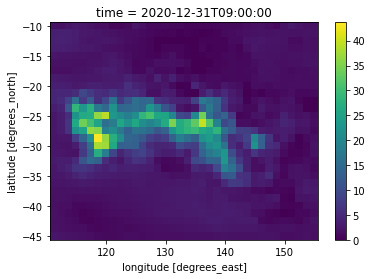

In [7]:
FFDI.sel(time='2020-12-31').plot()